0.0009913025423999972
-0.0008260854520000006


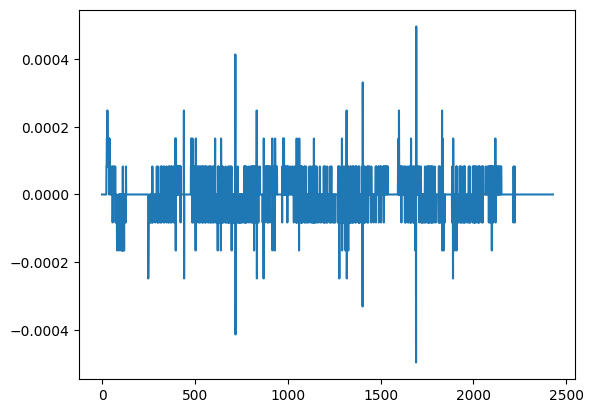

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_excel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow import keras

# Convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return array(diff)

def prepare_data(series, n_test, n_lag, n_seq):
    # Extract raw values
    raw_values = series.values
    # Difference data to make it stationary
    diff_series = difference(raw_values, 1)
    # Rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_series.reshape(-1, 1))
    print(max(diff_series))
    print(min(diff_series))
    # Transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # Split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    # Inverse transform test set to get original values
    test_values = scaler.inverse_transform(test[:, :])[:, 0]  # Extract actual values

    return scaler, train, test, test_values  # Return all needed data




def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # Assume train, n_lag, nb_epoch, n_batch are defined elsewhere
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], n_lag, 1)  # Reshape X for LSTM
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2]),unroll=True)) # Remove batch_input_shape
    #model.add(Dense(y.shape[1],'tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=0)
    return model
# Make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # Reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, len(X), 1)  # Ensure there's one feature per timestep
    # Make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # Convert to array
    return [x for x in forecast[0, :]]

# Evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # Make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # Store the forecast
        forecasts.append(forecast)
    return forecasts

# Invert differenced forecast
def inverse_difference(last_ob, forecast):
    # Invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# Inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # Create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # Invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # Invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # Store
        inverted.append(inv_diff)
    return inverted

# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # Plot the entire dataset in blue
    pyplot.plot(series.values)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # Show the plot
    pyplot.show()

# Load dataset
csv_path = 'TorqueData_noFriction_NL_NG.xlsx'
series = pd.read_excel(csv_path)
series = series['Torque']
# Configure
n_lag = 5
n_seq = 1
n_test = round(0.3 * len(series))  # Or whatever number of tests you want
n_epochs = 20  # Number of epochs for training
n_batch = 1  # Batch size
n_neurons = 2  # Number of neurons in the LSTM layer
pyplot.plot(series.values)
# Prepare data
scaler, train, test,test_values = prepare_data(series, n_test, n_lag, n_seq)

C:\Users\malth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

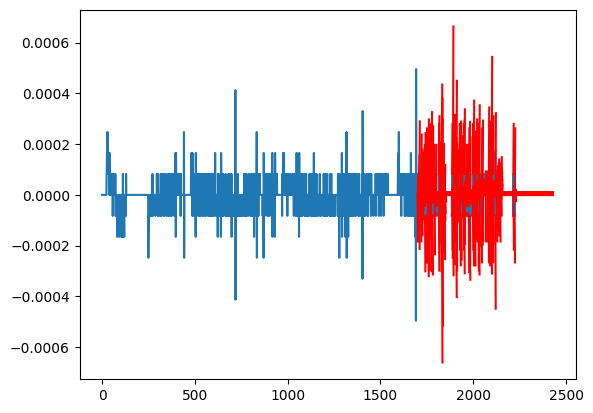

In [2]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
model.save('LSTMMM2.keras') # Add .keras extension to the filename
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts_diff=forecasts
# inverse transform forecasts and test

forecasts = inverse_transform(series, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test)

In [3]:
import bluetooth
import serial
import glob
import sys
import time
import struct
baud = 250000
dataNumBytes = 1
CONNECTED = False
POST_PROCESSING_DONE = False
PREDICTING = True
s = serial.Serial(baudrate=baud,timeout=3, write_timeout=3,bytesize=8)
Torques1 = [0.0,0.0,0.0,0.0,0.0,0.0]
Torques2 = [0.0,0.0,0.0,0.0,0.0,0.0]
TorquePre = [0.0,0.0]
def get_serial_ports():
    """
    Lists serial ports.
    :return: ([str]) A list of available serial ports
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        #ports = glob.glob('/dev/tty[A-Za-z]*')
        #ports = glob.glob('/dev/[A-Za-z]*')
        ports = glob.glob('/dev/rfcomm*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    results = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            results.append(port)
        except (OSError, serial.SerialException):
            pass
    print("{}\n".format(results))
    return results

def connect():
    print("Attempting connection... Please wait.")
    serial_ports = get_serial_ports() 
    for serial_port in serial_ports:
        s.port = serial_port
        print("Handshaking at port: {}".format(serial_port))
        try:
            s.open()
            s.write(b'k')
            time.sleep(1)
            print("Bytes inWaiting: {}".format(s.in_waiting))
            handshake_return = s.read(1)
            print("Acknowledgement recieved: {}".format(handshake_return))               
            if handshake_return == b'M':
                print("Motor device found at port: {}".format(serial_port))
                CONNECTED = True
                print("Connected = {}".format(CONNECTED))
                s.reset_input_buffer()
                break
            else:
                s.close()
                print("no device")    
        except:
            if s.is_open:
                s.close()
            continue
def get_sample():        
        data_buffer = list()
        data = s.read(2)
        if len(data) == 2:
            for j in range(2):
                value = struct.unpack('B', data[j])
                data_buffer.append(value)
        else:
            data_buffer = [0.0,0.0]
        return data_buffer

connect()


Attempting connection... Please wait.
['COM10', 'COM11', 'COM33', 'COM34']

Handshaking at port: COM10
Bytes inWaiting: 0
Acknowledgement recieved: b''
no device
Handshaking at port: COM11
Bytes inWaiting: 0
Acknowledgement recieved: b''
no device
Handshaking at port: COM33
Handshaking at port: COM34
Bytes inWaiting: 1
Acknowledgement recieved: b'M'
Motor device found at port: COM34
Connected = True


In [4]:
def receive_float_from_esp32():
    # Read line from serial and decode it to a float
    line = s.readline().decode('utf-8').strip()
    if line:
        try:
            received_value = float(line)
            print(f"Received float from ESP32 via Bluetooth: {received_value}")
            return received_value
        except ValueError:
            print("Error: Could not convert received data to float.")
    return None

In [5]:
n_test = 5
def prepare_dataNew(series, n_test, n_lag, n_seq):
    # Extract raw values
    raw_values = series
    # Difference data to make it stationary
    diff_series = difference(raw_values, 1)
    # Rescale values to -1, 1
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_series.reshape(-1, 1))
    print(max(diff_series))
    print(min(diff_series))
    # Transform into supervised learning problem X, y
    # Split into train and test sets
    test = scaled_values

    return scaler,test  # Return all needed data
def forecast_lstm(model, X, n_batch):
    # Reshape input pattern to [samples, timesteps, features]
    #  # Ensure there's one feature per timestep
    X = X.reshape(1, len(X), 1) 
    # Make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # Convert to array
    return [x for x in forecast[0, :]]

# Evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # Make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # Store the forecast
        forecasts.append(forecast)
    return forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # Create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # Invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # Invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # Store
        inverted.append(inv_diff)
    return inverted
def plot_forecasts(series, forecasts, n_test):
    # Plot the entire dataset in blue
    pyplot.plot(series)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # Show the plot
    pyplot.show()

In [9]:
s.write(b'S')
v = 0
actualTau =list()
predictedTau = list()
while v < 100:
# Extract raw values
    pre1 = TorquePre[0]
    pre2 = TorquePre[1]
    s.write(b'G')
    s.write(b'r')
    s.write(b'm')
    s.write(b'p')
    s.write(b',')
    s.write(b'{pre1}')
    s.write(b',')
    s.write(b'{pre2}')
    s.write(b',')
    s.write(b'T')


    torque_data1 = receive_float_from_esp32()
    Torques1[0] = Torques1[1]
    Torques1[1] = Torques1[2]
    Torques1[2] = Torques1[3]
    Torques1[3] = Torques1[4]
    Torques1[4] = Torques1[5]
    Torques2[0] = Torques2[1]
    Torques2[1] = Torques2[2]
    Torques2[2] = Torques2[3]
    Torques2[3] = Torques2[4]
    Torques2[4] = Torques2[5]
    Torques1[5] = torque_data1
    Torques2[5] = torque_data1
    scaler, test = prepare_dataNew(Torques1,n_test,n_lag,n_seq)
    print(test)
    X = test.reshape((1,5,1))
    torquePrediction = model.predict(X)
    forecast = inverse_transform(Torques1, torquePrediction, scaler, n_test)
    TorquePre = [forecast[0][1], forecast[0][1]]
    print("printing forecast")
    print(forecast)

    actualTau.append(torque_data1)
    predictedTau.append(forecast[0][1])
    v=v+1
    time.sleep(0.5)

Received float from ESP32 via Bluetooth: -0.10544
0.323857
-0.5752349999999999
[[ 0.55729336]
 [-0.05931095]
 [ 1.        ]
 [-1.        ]
 [ 0.7255609 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
printing forecast
[[-0.4364990149345398, -0.830131128868103]]
Received float from ESP32 via Bluetooth: -0.082918
0.323857
-0.5752349999999999
[[-0.05931095]
 [ 1.        ]
 [-1.        ]
 [ 0.7255609 ]
 [ 0.3296904 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
printing forecast
[[-0.3797878093662262, -0.8472832508029937]]
Received float from ESP32 via Bluetooth: 0.088891
0.323857
-0.5752349999999999
[[ 1.        ]
 [-1.        ]
 [ 0.7255609 ]
 [ 0.3296904 ]
 [ 0.66177432]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
printing forecast
[[-0.6010493054351806, -1.142740489479065]]
Received float from ESP32 via Bluetooth: -0.021219
0.20048399999999997
-0.5752349999999999
[[-1.        ]
 [ 1.        ]
 [ 0.5411689 ]
 [ 0.92606859]
 [ 0.19921002]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
printing forecast
[[-0.28909

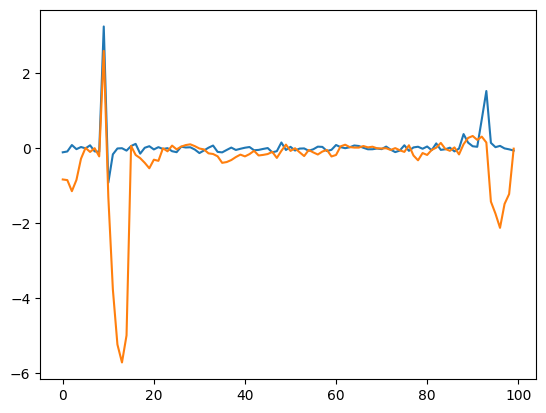

In [10]:

pyplot.plot(actualTau)
pyplot.plot(predictedTau)
pyplot.show()